# TF-IDF custom weights

In this notebook, we will attempt to add custom weights to certain parameters of the recommender model.

In [41]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender
import pickle
import copy
import psycopg2

Before running this notebook:
1. Create a PostgreSQL database with the following options:\
    dbname="training_database",\
    user="postgres",\
    password="default",\
    host="localhost",\
    port="5432"

2. From the root directory of this system, run the following command:\
`psql -U postgres -f data_system/data_storage/pg_dump.sql training_database`

This will create a PostgreSQL database with all the metadata in the SQL dump file (pg_dump.sql).

Now, we will connect to that database and extract all the metadata into a pandas data frame.

In [74]:
# Connect to the database with metadata
conn = psycopg2.connect(
    dbname="training_database",
    user="postgres",
    password="default",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

cursor.execute('SELECT * from dataset LIMIT 1')
column_names = [desc[0] for desc in cursor.description]

# Create pandas data frame with metadata
cursor.execute('SELECT * from dataset')
metadata = DataFrame(cursor.fetchall(), columns=column_names)
conn.close()
cursor.close()

# why is each sports dataset duplicated three times???
metadata = metadata.drop_duplicates(subset="title", keep="first").reset_index(drop=True) 
metadata.head()


,id,topic,title,description,source,url,tags,licenses,col_names,row_count,col_count,entry_count,null_count,usability
0,77,sports,in-vehicle coupon recommendation,"Source:\n\nTong Wang, tong-wang '@' uiowa.edu,...",kaggle,kaggle.com/datasets/mathurinache/invehicle-cou...,"{""automobiles and vehicles"",tabular}",{CC0-1.0},"{destination,passanger,weather,temperature,tim...",12684,26,329784,13370,1.000000
1,78,sports,IPL Dataset 2008-2016,**The Indian Premier League (IPL**) is a profe...,kaggle,kaggle.com/datasets/bhanupratapbiswas/ipl-data...,"{football,cricket}","{""ODC Public Domain Dedication and Licence (PD...","{season,city,team1,team2,toss_winner,toss_deci...",577,16,9232,590,1.000000
2,79,sports,IPL 2022 Player Statistics,### Context\nMany of us have watched the movie...,kaggle,kaggle.com/datasets/vora1011/ipl-2022-player-s...,"{cricket,india,beginner,tabular,pandas}",{CC0-1.0},"{Name,Team,Url,Type,ValueinCR,""Full Name"",Born...",474,78,18486,5796,1.000000
3,80,sports,Khelo India Scheme,### Content\n\nSports/State-wise Details of Pl...,kaggle,kaggle.com/datasets/santoshd3/statewise-player...,"{games,sports}",{other},"{Sl.No,""Sports Discipline"",""Andhra Pradesh"",""A...",17,39,663,418,0.970588
4,81,sports,Kids Hobby Prediction Dataset,### Context\nTeenagers tend to have confusion ...,kaggle,kaggle.com/datasets/abtabm/hobby-prediction-basic,"{art,sports,education,psychology,beginner}",{copyright-authors},"{Olympiad_Participation,Scholarship,School,Fav...",1601,14,22414,0,0.764706


Here is some information about the metadata pulled in:

In [75]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           868 non-null    int64  
 1   topic        868 non-null    object 
 2   title        868 non-null    object 
 3   description  868 non-null    object 
 4   source       868 non-null    object 
 5   url          868 non-null    object 
 6   tags         868 non-null    object 
 7   licenses     868 non-null    object 
 8   col_names    868 non-null    object 
 9   row_count    868 non-null    int64  
 10  col_count    868 non-null    int64  
 11  entry_count  868 non-null    int64  
 12  null_count   868 non-null    int64  
 13  usability    868 non-null    float64
dtypes: float64(1), int64(5), object(8)
memory usage: 95.1+ KB


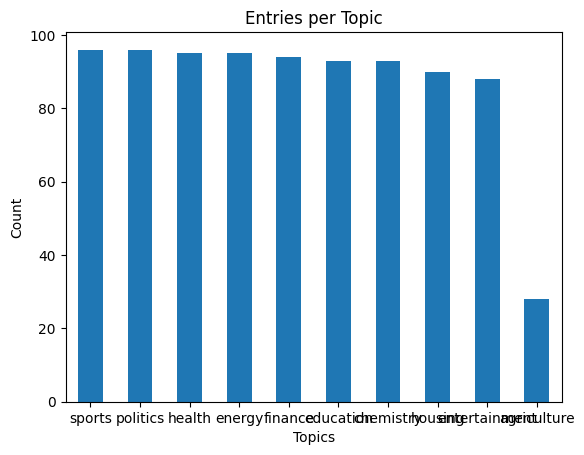

In [76]:
topic_counts = metadata['topic'].value_counts()

topic_counts.plot(kind='bar')
plt.title('Entries per Topic')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [77]:
all_tags = metadata['tags'].tolist()
all_tags = [tag for tags_list in all_tags for tag in tags_list]
unique = set(all_tags)
num_tags= len(unique)

print(f"Number of unique tags: {num_tags}")

Number of unique tags: 40


### 2. Instantiate the recommender

These are the following tokenization methods available out-of-the-box with this implementation:

| tokenization_method | Description                                                                                                                      |
|:--------------------|:---------------------------------------------------------------------------------------------------------------------------------|
| 'none'              | No tokenization is applied. Each word is considered a token.                                                                     |
| 'nltk'              | Simple stemming is applied using NLTK.                                                                                           |
| 'bert'              | HuggingFace BERT word tokenization ('bert-base-cased') is applied.                                                               |
| 'scibert'           | SciBERT word tokenization ('allenai/scibert_scivocab_cased') is applied.<br>This is recommended for scientific journal articles. |

<i>Source: [Microsoft Recommender](https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/tfidf_covid.ipynb)</i>

In [78]:
# TODO: Recommender breaks if another tokenization method is used
recommender = TfidfRecommender(id_col='id', tokenization_method='scibert')

### 3. Prepare text for use in the TF-IDF model

Here we will...

In [79]:
# Assign columns to clean and combine
cols_to_clean = ["topic", "title", "description"]
clean_col = 'cleaned_text'


# metadata = metadata.astype(str) # combined columns have to all be strings
metadata[cols_to_clean] = metadata[cols_to_clean].applymap(lambda x: x.lower())

# Weighting a column by artificially inlfating its term frequency by repeating the column weight times.
# On 10/26, Nancy suggested that this is unnecessary, and weighting should instead be done on the final matrix.
    # column_to_weight = "Title"
    # weight = 5
    # metadata[column_to_weight] = metadata[column_to_weight].apply(lambda x: (x + ' ') * weight).str.rstrip()

# Combine the following columns into the one used as input in to TF-IDF
df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)

df_clean.head()

,id,topic,title,description,source,url,tags,licenses,col_names,row_count,col_count,entry_count,null_count,usability,cleaned_text
0,77,sports,in-vehicle coupon recommendation,"source:\n\ntong wang, tong-wang '@' uiowa.edu,...",kaggle,kaggle.com/datasets/mathurinache/invehicle-cou...,"{""automobiles and vehicles"",tabular}",{CC0-1.0},"{destination,passanger,weather,temperature,tim...",12684,26,329784,13370,1.000000,sports invehicle coupon recommendation source...
1,78,sports,ipl dataset 2008-2016,**the indian premier league (ipl**) is a profe...,kaggle,kaggle.com/datasets/bhanupratapbiswas/ipl-data...,"{football,cricket}","{""ODC Public Domain Dedication and Licence (PD...","{season,city,team1,team2,toss_winner,toss_deci...",577,16,9232,590,1.000000,sports ipl dataset 20082016 the indian premier...
2,79,sports,ipl 2022 player statistics,### context\nmany of us have watched the movie...,kaggle,kaggle.com/datasets/vora1011/ipl-2022-player-s...,"{cricket,india,beginner,tabular,pandas}",{CC0-1.0},"{Name,Team,Url,Type,ValueinCR,""Full Name"",Born...",474,78,18486,5796,1.000000,sports ipl 2022 player statistics context man...
3,80,sports,khelo india scheme,### content\n\nsports/state-wise details of pl...,kaggle,kaggle.com/datasets/santoshd3/statewise-player...,"{games,sports}",{other},"{Sl.No,""Sports Discipline"",""Andhra Pradesh"",""A...",17,39,663,418,0.970588,sports khelo india scheme content sportsstat...
4,81,sports,kids hobby prediction dataset,### context\nteenagers tend to have confusion ...,kaggle,kaggle.com/datasets/abtabm/hobby-prediction-basic,"{art,sports,education,psychology,beginner}",{copyright-authors},"{Olympiad_Participation,Scholarship,School,Fav...",1601,14,22414,0,0.764706,sports kids hobby prediction dataset context ...


In [80]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)
tf

TfidfVectorizer(min_df=0, ngram_range=(1, 3), stop_words='english')

In [81]:
vectors_tokenized

0      sports inv ##eh ##icle cou ##pon recommendatio...
1      sports ip ##l dataset 2008 ##201 ##6 the ind #...
2      sports ip ##l 202 ##2 player statistics contex...
3      sports k ##hel ##o ind ##ia scheme content spo...
4      sports kid ##s ho ##bb ##y prediction dataset ...
                             ...                        
863    enter ##tainment wal ##t dis ##ney character d...
864    enter ##tainment warrant ##y claims with only ...
865    enter ##tainment windows store context this da...
866    enter ##tainment world happiness report contex...
867    enter ##tainment y ##ug ##io ##h dec ##ks info...
Name: cleaned_text, Length: 868, dtype: object

### 4. Recommend articles using TF-IDF

In [82]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

In [51]:
# (DOES NOT WORK, UNABLE TO SERIALIZE RECOMMENDATIONS ATTRIBUTE) Serialize model
# model_path = Path("../../backend/models/v2_model.pkl")
# with open(model_path, 'wb') as file:
#     pickle.dump(recommender, file)

In [83]:
# Get recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=10)

In [84]:
# full recommendation matrix
full_rec_matrix = recommender.recommendations
len(full_rec_matrix)

868

In [54]:
# recommendations_path = Path("../../backend/models/recommendations.pkl")
# with open(recommendations_path, 'wb') as file:
#     pickle.dump(full_rec_list, file)

In our recommendation table, each row represents a single recommendation.

- **UID** corresponds to the article that is being used to make recommendations from.
- **rec_rank** contains the recommdation's rank (e.g., rank of 1 means top recommendation).
- **rec_score** is the cosine similarity score between the query article and the recommended article.
- **rec_cord_uid** corresponds to the recommended article.

In [85]:
article_of_interest = 430
print('Number of recommended articles for ' + str(article_of_interest) + ': ' + str(len(full_rec_matrix[article_of_interest])))

Number of recommended articles for 430: 867


In [87]:
metadata[metadata["id"] == article_of_interest]

,id,topic,title,description,source,url,tags,licenses,col_names,row_count,col_count,entry_count,null_count,usability
387,430,finance,apple (aapl) stock data,this dataset offers a granular look at the dai...,kaggle,kaggle.com/datasets/guillemservera/aapl-stock-...,"{business,finance,investing}","{""Attribution-NoDerivatives 4.0 International ...","{date,open,high,low,close,volume,adjusted_clos...",19650,18,176850,40,1.0


In [88]:
# Optionally view tokens
tokens = recommender.get_tokens()
# Preview 10 tokens
print(list(tokens.keys())[:10])
# Preview just the first 10 stop words sorted alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['sports', 'inv', 'eh', 'icle', 'cou', 'pon', 'recommendation', 'source', 'ton', 'wa']
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [89]:
# Final Recs
cols_to_keep = cols_to_clean
recommender.get_top_k_recommendations(metadata,article_of_interest,cols_to_keep)
# TODO: why cant display UID??

,rank,similarity_score,topic,title,description
0,1,0.763942,finance,tesla (tsla) stock data,"this dataset offers a granular look at the daily open, high, low, close, and volume (ohlcv) data for some of the tesla, inc. stock (tsla) updated every trading day, it aims to serve as a resource for researchers, traders, and finance enthusiasts. key features: - ohlcv: the foundational data points for any financial analysis. - adjusted close: this considers dividends and splits, offering a true reflection of value over time. - change %: offers a day-to-day percentage change, capturing market momentum. - 20 day average volume: a rolling metric to gauge trading liquidity and interest over roughly a month. **split adjusted:** given its history of stock splits, a separate dataset with split-adjusted data is available, ensuring accuracy in historical comparisons. --- image source: https://wallpapercave.com/w/wp3544524"
1,2,0.115099,finance,snp 500 dataset,"the dataset contains the stock price information of the s&p 500 from 1927 till june 2023 with features such as date, open, high, low, close, volume, dividends and splits. the dataset can be used for eda as well as time series analysis."
2,3,0.085950,finance,tesla stock price,"# context the subject matter of this dataset explores tesla's stock price from its initial public offering (ipo) to yesterday. # content within the dataset one will encounter the following: 1. the date - ""date"" 2. the opening price of the stock - ""open"" 3. the high price of that day - ""high"" 4. the low price of that day - ""low"" 5. the closed price of that day - ""close"" 6. the amount of stocks traded during that day - ""volume"" 7. the stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open - ""adj[usted] close"" # acknowledgements through python programming and checking sentdex out, i acquired the data from yahoo finance. the time period represented starts from 06/29/2010 to 03/17/2017. # inspiration what happens when the volume of this stock trading increases/decreases in a short and long period of time? what happens when there is a discrepancy between the adjusted close and the next day's opening price?"
3,4,0.081533,finance,euro to usd conversion,"# content this dataset contains daily information about euro to usd conversion (in usd) with comma-separated values. the data contains information from december 1, 2003 until present. there are 7 columns: - date - open - high - low - close - adjusted close price for splits and dividend and/or capital gain distributions - volume # acknowledgements thanks to yahoo finance!"
4,5,0.077318,finance,finance data (s&p 500),"### content it's a time series dataset of sp500. the s&p 500, or simply the s&p, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the united states. it is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the u.s. stock market. date: date of the stock data close/last: last close price of the company's shares on the relevant stock exchange volume: number of shares sold, traded over a certain period of time (usually daily) open: opening price of company's shares high: highest price at which a stock traded during the trading day low: lowest price at which a stock traded during the trading day ### inspiration perform time series analysis concept on real world scenario and forecast future stock price on real world data and gain some knowledge. have a fun !!!"


In [59]:
# Final matrix result of all recommendations from TF-IDF
# full_rec_matrix

### 5. Weighting for specific features

`full_rec_matrix` now has the raw TF-IDF scores calcualted for each dataset's title, topic, and description.
The aim is to now further refine these scores based on specific features of these datasets:

- Increase the similarity score if datasets have the same license
- Increase the similarity score if datasets share the same tag
- Increase the similarity score if this specific recommendation is positively rated

In [90]:
# Only run once
metadata.set_index('id', inplace=True) # to index directly into metadata rows

These are the current recommendations for the given article of interest before weighting:

In [91]:
uid_of_interest = 678
metadata.loc[uid_of_interest]

topic                                                   politics
title                        member states of the european union
description    # context \n\nthe european union is a unique e...
source                                                    kaggle
url                  kaggle.com/datasets/eurostat/european-union
tags             {government,politics,"international relations"}
licenses                                               {CC0-1.0}
col_names      {Country,"European Union","Accession Year","Co...
row_count                                                     37
col_count                                                     17
entry_count                                                  629
null_count                                                    80
usability                                               0.823529
Name: 678, dtype: object

In [92]:
old_rec_list = copy.deepcopy(full_rec_matrix[uid_of_interest])
old_rec_list_UIDs = [uid for _, uid in old_rec_list]
metadata_sorted_old_recs = metadata.reindex(old_rec_list_UIDs).reset_index()
metadata_sorted_old_recs.head()

,id,topic,title,description,source,url,tags,licenses,col_names,row_count,col_count,entry_count,null_count,usability
0,550,energy,european energy consumption data,,kaggle,kaggle.com/datasets/deepikakoche/european-ener...,{energy},{unknown},"{""Unnamed: 0"",gdp,energy}",20,3,60,0,0.294118
1,531,energy,co2 intensity of electricity generation,## description\nelectricity generation gives r...,kaggle,kaggle.com/datasets/mathchi/co2-intensity-of-e...,"{europe,energy}","{""EU ODP Legal Notice""}","{CountryShort,CountryLong,Year,ValueNumeric,Un...",924,6,5544,0,1.000000
2,141,education,access to education of disabled people in europe,## context\n\ndata about access to education a...,kaggle,kaggle.com/datasets/gpreda/access-to-education...,"{europe,education,beginner,tabular,""health con...",{CC0-1.0},"{unit,isced97,hlth_pb,sex,age,time,geo,value}",13950,8,111600,2890,1.000000
3,645,politics,2016 eu referendum in the united kingdom,# context \n\na referendum was held on the 23 ...,kaggle,kaggle.com/datasets/electoralcommission/brexit...,"{government,politics,""social science"",demograp...",{CC0-1.0},"{Type,Code,Area,""All Residents"",""Age 0 to 4"",""...",832,44,18372,66,0.823529
4,534,energy,dutch energy generation,this dataset contains **dutch energy generatio...,kaggle,kaggle.com/datasets/maxscheijen/dutch-energy-g...,"{energy,""renewable energy"",""time series analys...",{CC-BY-SA-4.0},"{MTU,Biomass,""Fossil Brown coal/Lignite"",""Foss...",41764,22,918808,459716,1.000000


In [93]:
def extract_strings(uid, col_name):
    strings = metadata.loc[uid][col_name]
    strings = strings.strip("{}").replace('"',"")
    return {string.lower() for string in strings.split(',')}

LICENSES_WEIGHT = 1.1
TAGS_WEIGHT = 1.1
COLUMN_NAMES_WEIGHT = 1.05

for (rec_from_uid, rec_list) in full_rec_matrix.items():
    for (original_score,rec_to_uid) in rec_list:
        
        # keep track of weight that will be applied to this recommendation
        weight = 1
        
        # Increase score if datasets have the same license
        if(metadata.loc[rec_from_uid]['licenses'] == metadata.loc[rec_to_uid]['licenses']):
            weight *= LICENSES_WEIGHT

        # Increase score by the number of shared tags
        from_tags = extract_strings(rec_from_uid, "tags")
        to_tags = extract_strings(rec_to_uid, "tags")
        num_shared_tags = len(from_tags & to_tags)
        weight *= TAGS_WEIGHT ** num_shared_tags

        # Increase score by the number of column names
        from_cols = extract_strings(rec_from_uid, "col_names")
        to_cols = extract_strings(rec_to_uid, "col_names")
        num_shared_cols = len(from_cols & to_cols)
        weight *= COLUMN_NAMES_WEIGHT ** num_shared_cols

        # Apply the weight to this recommendation
        if(weight != 1):
            index = next((i for i, rec in enumerate(rec_list) if rec[1] == rec_to_uid), None)
            weighted_recommendation = (original_score * weight, rec_to_uid)
            rec_list[index] = weighted_recommendation

    # Reorder the recommendations based on their new weights
    rec_list.sort(key=lambda x: x[0], reverse=True)

And now these are the recommendations after weighting...

In [94]:
new_rec_list = full_rec_matrix[uid_of_interest]
new_rec_list_UIDs = [uid for _, uid in new_rec_list]
metadata_sorted = metadata.reindex(new_rec_list_UIDs).reset_index()
metadata_sorted.head()

,id,topic,title,description,source,url,tags,licenses,col_names,row_count,col_count,entry_count,null_count,usability
0,550,energy,european energy consumption data,,kaggle,kaggle.com/datasets/deepikakoche/european-ener...,{energy},{unknown},"{""Unnamed: 0"",gdp,energy}",20,3,60,0,0.294118
1,645,politics,2016 eu referendum in the united kingdom,# context \n\na referendum was held on the 23 ...,kaggle,kaggle.com/datasets/electoralcommission/brexit...,"{government,politics,""social science"",demograp...",{CC0-1.0},"{Type,Code,Area,""All Residents"",""Age 0 to 4"",""...",832,44,18372,66,0.823529
2,141,education,access to education of disabled people in europe,## context\n\ndata about access to education a...,kaggle,kaggle.com/datasets/gpreda/access-to-education...,"{europe,education,beginner,tabular,""health con...",{CC0-1.0},"{unit,isced97,hlth_pb,sex,age,time,geo,value}",13950,8,111600,2890,1.000000
3,531,energy,co2 intensity of electricity generation,## description\nelectricity generation gives r...,kaggle,kaggle.com/datasets/mathchi/co2-intensity-of-e...,"{europe,energy}","{""EU ODP Legal Notice""}","{CountryShort,CountryLong,Year,ValueNumeric,Un...",924,6,5544,0,1.000000
4,534,energy,dutch energy generation,this dataset contains **dutch energy generatio...,kaggle,kaggle.com/datasets/maxscheijen/dutch-energy-g...,"{energy,""renewable energy"",""time series analys...",{CC-BY-SA-4.0},"{MTU,Biomass,""Fossil Brown coal/Lignite"",""Foss...",41764,22,918808,459716,1.000000


#### This is what happened to those similarity scores

In [95]:
old_rec_list

[(0.2955119752238722, 550),
 (0.17408496901470907, 531),
 (0.16417257889131445, 141),
 (0.1398677347030667, 645),
 (0.1075844594982797, 534),
 (0.1005619129744921, 114),
 (0.09299249912545325, 852),
 (0.08209795540269967, 268),
 (0.07658596110218366, 565),
 (0.0689749916863101, 777),
 (0.06729205135575027, 537),
 (0.055733624411525094, 131),
 (0.049957867532223706, 467),
 (0.04955601343879053, 863),
 (0.048847050254008456, 812),
 (0.046402586897398276, 176),
 (0.042997186747460184, 813),
 (0.04256835276597098, 762),
 (0.04127082999372813, 551),
 (0.040997523255905055, 567),
 (0.039988149574541304, 241),
 (0.03881350824966665, 757),
 (0.036984859188848175, 811),
 (0.03492464632195207, 487),
 (0.034806287278623116, 854),
 (0.03366317383315977, 851),
 (0.03188885463280655, 468),
 (0.030973861697975995, 640),
 (0.030633527866124922, 816),
 (0.03063140731141282, 857),
 (0.028980619645420175, 394),
 (0.028867123683603696, 697),
 (0.028133598450182512, 180),
 (0.02774605266554141, 393),
 (0.0

In [96]:
new_rec_list

[(0.2955119752238722, 550),
 (0.18616395488978185, 645),
 (0.1805898367804459, 141),
 (0.17408496901470907, 531),
 (0.1075844594982797, 534),
 (0.10229174903799858, 852),
 (0.1005619129744921, 114),
 (0.08424455721240202, 565),
 (0.08209795540269967, 268),
 (0.07587249085494112, 777),
 (0.07402125649132531, 537),
 (0.06130698685267761, 131),
 (0.0511588520543816, 176),
 (0.049957867532223706, 467),
 (0.04955601343879053, 863),
 (0.048847050254008456, 812),
 (0.047667808642756, 551),
 (0.045097275581495566, 567),
 (0.04398696453199544, 241),
 (0.042997186747460184, 813),
 (0.04271751236311965, 811),
 (0.04256835276597098, 762),
 (0.041226209920006064, 640),
 (0.03881350824966665, 757),
 (0.038417110954147286, 487),
 (0.034806287278623116, 854),
 (0.033694548042554104, 857),
 (0.03366317383315977, 851),
 (0.03334152785456228, 697),
 (0.03188885463280655, 468),
 (0.030946958295200767, 180),
 (0.030633527866124922, 816),
 (0.03015065024379419, 675),
 (0.030033622681827746, 919),
 (0.029238